In [1]:
import os
from tqdm import tqdm
import cv2
import pickle
import math
import matplotlib.pyplot as plt
import gc
import time
import json
import shutil
from collections import defaultdict
import pycocotools.coco as coco
import copy

In [2]:
raw_video_data_path = "/pfs/data5/home/kit/tm/px6680/Conference/Syntra/data/temp_set/"

images_save_path    = "/pfs/data5/home/kit/tm/px6680/Conference/Syntra/data/temp_set_images/"

resize_image        = False
resize_with         = 640
resize_height       = 640


coco_root_path      = "/pfs/data5/home/kit/tm/px6680/Conference/Syntra/data/"
coco_root_path      = os.path.join(coco_root_path,"notebook_data")
if not os.path.exists(coco_root_path):
    os.makedirs(coco_root_path)
    
annotation_path     = os.path.join(coco_root_path,"annotations")
if not os.path.exists(annotation_path):
    os.makedirs(annotation_path)

# Data Statistic

In [3]:

video_list  = os.listdir(raw_video_data_path)
video_list  = [i for i in video_list if "pickle" not in i]
video_dict  = {} # senario
label_dict  = {}
for video in tqdm(video_list):

    senario = video.split("_")[0]
    if senario in video_dict.keys():
        video_dict[senario] = video_dict[senario] + 1
    else:
        video_dict[senario] = 1

    videoName = os.path.join(raw_video_data_path,video)
    pickleName = videoName + ".pickle"

    with open(pickleName, "rb") as f:
        data = pickle.load(f)

    correct_list = data["correct_list"]

    for f in range(data["start_frame"],data["stop_frame"]):
        for frame_annotation in correct_list[f]:
            obj_class = frame_annotation["class"]

            if obj_class in label_dict.keys():
                label_dict[obj_class] = label_dict[obj_class] + 1
            else:
                label_dict[obj_class]  = 1


100%|██████████| 5/5 [00:00<00:00, 107.91it/s]


In [4]:
video_dict

{'station1': 5}

In [5]:
label_dict

{'car': 994, 'truck': 352, 'van': 577, 'bus': 45}

# Extract Images From the Videos

In [6]:
video_list = os.listdir(raw_video_data_path)
video_list = [i for i in video_list if "pickle" not in i]


for video in tqdm(video_list):

    filename = os.path.join(images_save_path,video.split(".")[0])

    if not os.path.exists(filename):
        os.makedirs(filename)

    videoName = os.path.join(raw_video_data_path,video)

    #############
    ## PROGRAM ##
    #############
    ## From here the pickle is loaded and plotted:
    pickleName = videoName + ".pickle"
    with open(pickleName, "rb") as f:
        data = pickle.load(f)
    data_width   = int(data["width"])
    data_height  = int(data["height"])
    #video       = imageio.get_reader(videoName,  'ffmpeg')
    cap        = cv2.VideoCapture(videoName)
    correct_list = data["correct_list"]
    frame_index  = 0
    save_index   = 0
    while True:
        ret, image = cap.read()
        if frame_index<3:
            frame_index = frame_index + 1
            continue
        if not ret:
            break    
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if resize_image:
            image = cv2.resize(image, (resize_with,resize_height), interpolation= cv2.INTER_NEAREST)


        cv2.imwrite(os.path.join(filename,"{}.jpg".format(save_index)), image)
        file_object = open( os.path.join(filename ,"{}.txt".format(save_index)),"a")
        for frame_annotation in correct_list[frame_index]:
            minX = frame_annotation["x"]
            minY = frame_annotation["y"]
            w    = frame_annotation["w"]
            h    = frame_annotation["h"]
            obj_class = frame_annotation["class"]
            obj_id    = frame_annotation["oid"]
            obj_static= frame_annotation["static"]

            file_object.write(f"{obj_class} {minX} {minY} {w} {h} {obj_id} {obj_static} {data_width} {data_height}\n")
        file_object.close()
        frame_index = frame_index + 1
        save_index  = save_index + 1

    gc.collect()


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


# Visualize the images Check the Results

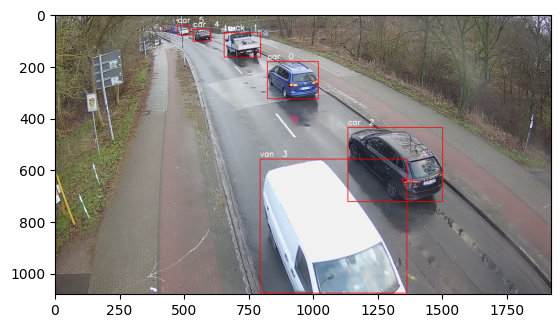

In [9]:

dir_list    = os.listdir(images_save_path)

# -------------- change the index -----------------------
video_index = 3
image_index = 50
# -------------- change the index -----------------------
img         = os.path.join(images_save_path,dir_list[video_index],"{}.jpg".format(image_index))
anno        = os.path.join(images_save_path,dir_list[video_index],"{}.txt".format(image_index))

image = cv2.imread(img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
f = open(anno, "r")
annotations = f.readlines()
f.close()
for ann in annotations:
    
    info_list = ann.split(" ")
    obj_class = info_list[0]
    img_width = int(info_list[7])
    img_height = int(info_list[8])
    
    minX = float(info_list[1])
    minY = float(info_list[2])
    w    = float(info_list[3])
    h    = float(info_list[4])

    
    obj_id    = int(info_list[5])
    
    cv2.rectangle(image, (int(minX), int(minY)), (int(minX+w), int(minY+h)), (255,0,0), 2)
    cv2.putText(image, obj_class+"  "+str(obj_id), (int(minX), int(minY-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(image);

# Convert the annotations as Coco Format
add the video id and frame id

## Training Data

In [10]:
flag = "train"
train_ratio = 0.8

video_list = os.listdir(images_save_path)

# TODO Split the data according to the sation name .
target_list = video_list[:int(len(video_list)*train_ratio)]


img_out_path = os.path.join(coco_root_path,"{}2017".format(flag))
if not os.path.exists(img_out_path):
    os.makedirs(img_out_path)


cats = list(label_dict.keys())
cat_ids = {cat: i + 1 for i, cat in enumerate(cats)}
cat_info = []
for i, cat in enumerate(cats):
    cat_info.append({'name': cat, 'id': i + 1})

ann_cnt   = 0
video_cnt = 0
image_cnt = 0

out = {'images': [], 
       'annotations': [], 
       'categories': cat_info,
       'videos': []}


for video_index in tqdm(range(len(target_list))):
    
    video_path = os.path.join(images_save_path , target_list[video_index])
    images_list = os.listdir(video_path)
    images_list = [i for i in images_list if "jpg" in i]
    num_images = len(images_list)
    image_range = [0, num_images - 1]
    
    video_cnt += 1
    out['videos'].append({
        'id': video_cnt,
        'file_name': target_list[video_index]})
    

    frame_id = 0
    for image_index in range(num_images):
        img_path  = os.path.join(video_path, "{}.jpg".format(image_index))
        anno_path = os.path.join(video_path, "{}.txt".format(image_index))
        
        shutil.copy(img_path, os.path.join(img_out_path ,'{}.jpg'.format(image_cnt + image_index + 1)))
                    
            
        image_info = {'file_name': '{}.jpg'.format(image_cnt + image_index + 1),
                      'id': image_cnt + image_index + 1,
                      'frame_id': frame_id + 1,
                      'prev_image_id': image_cnt + image_index if image_index > 0 else -1,
                      'next_image_id': image_cnt + image_index + 2 if image_index < num_images - 1 else -1,
                      'video_id': video_cnt}
        out['images'].append(image_info)
        frame_id = frame_id + 1

    


        f = open(anno_path, "r")
        annotations = f.readlines()
        f.close()
        for ann in annotations:
            ann_cnt      = ann_cnt + 1
            info_list    = ann.split(" ")
            minX         = float(info_list[1])
            minY         = float(info_list[2])
            w            = float(info_list[3])
            h            = float(info_list[4])
            obj_id       = cat_ids[info_list[0]]
            track_id     = int(info_list[5])

            ann = {'id': ann_cnt,
                   'category_id': obj_id,
                     'image_id': image_cnt + image_index + 1,
                     'track_id': track_id,
                     'bbox': [minX, minY, w, h]}
            out['annotations'].append(ann)

    


    image_cnt += num_images

out_path = os.path.join(annotation_path,"instances_{}2017.json".format(flag))
json.dump(out, open(out_path, 'w'))
            

100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


## TEST Data (Val)

In [11]:
flag = "val"
train_ratio = 0.5

video_list = os.listdir(images_save_path)


target_list = video_list[int(len(video_list)*train_ratio):]


img_out_path = os.path.join(coco_root_path,"{}2017".format(flag))
if not os.path.exists(img_out_path):
    os.makedirs(img_out_path)


cats = list(label_dict.keys())
cat_ids = {cat: i + 1 for i, cat in enumerate(cats)}
cat_info = []
for i, cat in enumerate(cats):
    cat_info.append({'name': cat, 'id': i + 1})

ann_cnt   = 0
video_cnt = 0
image_cnt = 0

out = {'images': [], 
       'annotations': [], 
       'categories': cat_info,
       'videos': []}


for video_index in tqdm(range(len(target_list))):
    
    video_path = os.path.join(images_save_path , target_list[video_index])
    images_list = os.listdir(video_path)
    images_list = [i for i in images_list if "jpg" in i]
    num_images = len(images_list)
    image_range = [0, num_images - 1]
    
    video_cnt += 1
    out['videos'].append({
        'id': video_cnt,
        'file_name': target_list[video_index]})
    

    frame_id = 0
    for image_index in range(num_images):
        img_path  = os.path.join(video_path, "{}.jpg".format(image_index))
        anno_path = os.path.join(video_path, "{}.txt".format(image_index))
        
        shutil.copy(img_path, os.path.join(img_out_path ,'{}.jpg'.format(image_cnt + image_index + 1)))
                    
            
        image_info = {'file_name': '{}.jpg'.format(image_cnt + image_index + 1),
                      'id': image_cnt + image_index + 1,
                      'frame_id': frame_id + 1,
                      'prev_image_id': image_cnt + image_index if image_index > 0 else -1,
                      'next_image_id': image_cnt + image_index + 2 if image_index < num_images - 1 else -1,
                      'video_id': video_cnt}
        out['images'].append(image_info)
        frame_id = frame_id + 1

    


        f = open(anno_path, "r")
        annotations = f.readlines()
        f.close()
        for ann in annotations:
            ann_cnt      = ann_cnt + 1
            info_list    = ann.split(" ")
            minX         = float(info_list[1])
            minY         = float(info_list[2])
            w            = float(info_list[3])
            h            = float(info_list[4])
            obj_id       = cat_ids[info_list[0]]
            track_id     = int(info_list[5])

            ann = {'id': ann_cnt,
                   'category_id': obj_id,
                     'image_id': image_cnt + image_index + 1,
                     'track_id': track_id,
                     'bbox': [minX, minY, w, h]}
            out['annotations'].append(ann)

    


    image_cnt += num_images

out_path = os.path.join(annotation_path,"instances_{}2017.json".format(flag))
json.dump(out, open(out_path, 'w'))
            

100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


# Check Data in Coco Format

In [12]:
flag = "train"
#flag = "val"
ann_path = os.path.join(annotation_path,"instances_{}2017.json".format(flag))
img_dir = os.path.join(coco_root_path,"{}2017".format(flag))
coco_data = coco.COCO(ann_path)
video_to_images = defaultdict(list)
for image in coco_data.dataset['images']:
    video_to_images[image['video_id']].append(image)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
images = coco_data.getImgIds()

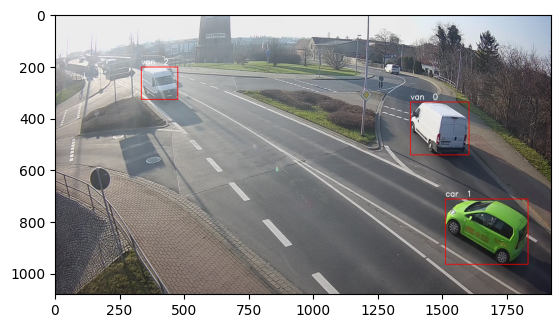

In [16]:
index = 2
img_id = images[index]
img_info = coco_data.loadImgs(ids=[img_id])[0]
file_name = img_info['file_name']
img_path = os.path.join(img_dir, file_name)
ann_ids = coco_data.getAnnIds(imgIds=[img_id])

anns = copy.deepcopy(coco_data.loadAnns(ids=ann_ids))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for ann in anns:
    bbox = ann["bbox"]
    track_id = ann["track_id"]
    category_id = ann["category_id"]
    cls = cats[category_id-1]
    cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])), (255,0,0), 2)
    cv2.putText(img, cls+"  "+str(track_id), (int(bbox[0]), int(bbox[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
plt.imshow(img);